# Communicated genes overrepresentation analysis

Performs the over-representation analysis of the direct and communicated gene sets using the Gene Ontology Biological Processes from the c5 collection in the [Molecular Signatures Database](https://www.gsea-msigdb.org/gsea/msigdb/).

In [1]:
import os
from json import dumps
import logging
import pandas as pd
import numpy as np
import math
import json
import copy

import matplotlib.pyplot as plt
from matplotlib import cm

import statsmodels.stats as sts

from CoRe import reader, fnGO

Read the gene sets and determine the list of unique genes.

In [2]:
total_genes = 17949
gene_set_cutoff = 373

Specify positive false discovery rate 

In [3]:
fdr = 0.01

The GOBP gene sets are stored as a dict in json format.

In [4]:
current_directory = os.getcwd()

go_directory = current_directory + "/Examples/GO_sets"
os.chdir(go_directory)

f = open(('GO_BPs.json'))
GO_BPs = json.load(f)
f.close()

bp_names = list(GO_BPs.keys())

for bp in GO_BPs.keys():
    GO_BPs[bp] = pd.DataFrame(GO_BPs[bp])

print('Total gene sets: ',len(list(GO_BPs.keys())))

wf = open('BP_embedding.csv')
all_lines = wf.readlines()
wf.close()

embed_idx = {}

for l in all_lines:
    all_values = l.rstrip('\r\n').split(',')

    embed_idx[int(all_values[0])] = []

    for k in all_values[1:]:
        embed_idx[int(all_values[0])].append(int(k))
        
        
bp_names = pd.read_csv('GOBP_list.csv',header=None)[0].to_list()

Total gene sets:  7481


In [5]:
go_directory = current_directory + "/Examples/GO_sets"
os.chdir(go_directory)

wf = open('BP_embedding.csv')
all_lines = wf.readlines()
wf.close()

embed_idx = {}

for l in all_lines:
    all_values = l.rstrip('\r\n').split(',')

    embed_idx[int(all_values[0])] = []

    for k in all_values[1:]:
        embed_idx[int(all_values[0])].append(int(k))
        
        
bp_names = pd.read_csv('GOBP_list.csv',header=None)[0].to_list()

Read the two sets of genes.

**PPI set:** Genes that have direct protein-protein interactions with SARS-CoV-2 proteins. <br>
**Total interaction set:** Genes that have either direct interaction or receive communication from SARS-CoV-2 proteins.

In [6]:
selected_pathway = 'Immune System'
pathway_nametag = selected_pathway.replace(' ','_')

network_type = 'medium-PPI'
state_type = 'high'

data_directory = current_directory + "/Examples/"+pathway_nametag
os.chdir(data_directory)


direct_interaction_set = reader.read_interactions_for_GO('SARS_CoV2-'+pathway_nametag+'_interactions.json')
total_interaction_set = reader.read_interactions_for_GO(state_type+'-SARS_CoV2_total_'+pathway_nametag+'_'+network_type+'_interactions.json')

Identify the sources, or SARS-CoV-2 proteins, that are causing communication. We determine this if for a SARS-CoV-2 protein the number of affected genes is greater than the number of genes that have PPI.

In [7]:
sources = []

print(f"{'SARS-CoV-2 protein'+'':<20} {'Directly interacting proteins'+'':<30} {'Direct and communicated proteins'+'':<25}")

for k in total_interaction_set.keys():
    if len(total_interaction_set[k])>len(direct_interaction_set[k]):
        sources.append(k)
        print(f"{k:<20} {len(direct_interaction_set[k]):<30} {len(total_interaction_set[k]):<25}")

SARS-CoV-2 protein   Directly interacting proteins  Direct and communicated proteins
SARS-CoV2 Nsp2       2                              3                        
SARS-CoV2 Nsp7       9                              28                       
SARS-CoV2 Nsp12      1                              11                       
SARS-CoV2 Nsp13      1                              4                        
SARS-CoV2 Nsp14      2                              7                        
SARS-CoV2 ORF3a      1                              4                        
SARS-CoV2 M          2                              33                       
SARS-CoV2 ORF8       7                              63                       
SARS-CoV2 ORF9b      1                              3                        
SARS-CoV2 ORF9c      2                              5                        
SARS-CoV2 ORF10      2                              5                        


In [8]:
go_tags, go_names, p_values = fnGO.compute_p_values(sources,GO_BPs,total_interaction_set,total_genes)#,size_threshold=gene_set_cutoff)

In [9]:
sel = []

for a,b in zip(go_names['SARS-CoV2 Nsp2'],p_values['SARS-CoV2 Nsp2']):
    if b<=fdr:
        print(a,'\t',b)
        sel.append(a)

POSITIVE REGULATION OF POSTTRANSCRIPTIONAL GENE SILENCING 	 0.005006109283145211
BILE ACID BIOSYNTHETIC PROCESS 	 0.0063382441851851335
RESPONSE TO DSRNA 	 0.008998945904068412
VERY LONG CHAIN FATTY ACID METABOLIC PROCESS 	 0.0056723254597296794
RESPONSE TO FUNGUS 	 0.00883279136529415
VERY LONG CHAIN FATTY ACID CATABOLIC PROCESS 	 0.0010025620305446883
RESPONSE TO PEPTIDOGLYCAN 	 0.0020044537499722234
BILE ACID METABOLIC PROCESS 	 0.008334216318953216
LIPID IMPORT INTO CELL 	 0.0056723254597296794
RESPONSE TO MURAMYL DIPEPTIDE 	 0.003339267057129244
POSITIVE REGULATION OF MIRNA MEDIATED INHIBITION OF TRANSLATION 	 0.0011695905271120611
LONG CHAIN FATTY ACID IMPORT INTO CELL 	 0.002838851634667231
FATTY ACID ALPHA OXIDATION 	 0.0015035916651381421


Save the GOBP gene sets that have a nontrivial raw $p$-value.

In [10]:
json_obj = json.dumps(go_tags)

f = open(state_type+'-all_nontrivial_GOs.json','w')
f.write(json_obj)
f.close()

Multiple hypothesis testing using Benjamini-Hochberg (BH) correction

In [11]:
q_values = {}

for s_g in sources:
    go_tags[s_g], go_names[s_g], q_values[s_g] = fnGO.compute_q_values(p_values[s_g],go_names[s_g],go_tags[s_g],0.5)

In [12]:
for a,b in zip(go_names['SARS-CoV2 Nsp2'],q_values['SARS-CoV2 Nsp2']):
    if a in sel:
        print(a,'\t',b)

VERY LONG CHAIN FATTY ACID CATABOLIC PROCESS 	 0.07216033499900004
POSITIVE REGULATION OF MIRNA MEDIATED INHIBITION OF TRANSLATION 	 0.07216033499900004
FATTY ACID ALPHA OXIDATION 	 0.07216033499900004
RESPONSE TO PEPTIDOGLYCAN 	 0.07216033499900004
LONG CHAIN FATTY ACID IMPORT INTO CELL 	 0.08014240937110186
RESPONSE TO MURAMYL DIPEPTIDE 	 0.08014240937110186
POSITIVE REGULATION OF POSTTRANSCRIPTIONAL GENE SILENCING 	 0.09075720735567487
VERY LONG CHAIN FATTY ACID METABOLIC PROCESS 	 0.09075720735567487
LIPID IMPORT INTO CELL 	 0.09075720735567487
BILE ACID BIOSYNTHETIC PROCESS 	 0.09127071626666591
BILE ACID METABOLIC PROCESS 	 0.09371363342628188
RESPONSE TO FUNGUS 	 0.09371363342628188
RESPONSE TO DSRNA 	 0.09371363342628188


In [13]:
go_idx = {}

for s in sources:
    go_idx[s] = []
    for go in go_tags[s]:
        go_idx[s].append(bp_names.index(go))

In [14]:
idx_to_remove = {}

for s in sources:
    idx_to_remove[s] = []
    
    k = 0
    
    for ii in go_idx[s]:
        idx_copy = copy.deepcopy(go_idx[s])
        idx_copy.remove(ii)
        
        d1 = pd.DataFrame(embed_idx[ii])
        d2 = pd.DataFrame(idx_copy)
        
        if len(d1)>0 and len(d2)>0:
            intersection = pd.merge(d1, d2, how='inner').drop_duplicates([0])
            len_intersection = int(intersection[0].count())

            if len_intersection>0:
                idx_to_remove[s].append(k)
                
        k += 1

In [15]:
for s_g in sources:
    if len(go_names[s_g])>0:
        idx_to_remove[s_g].reverse()
        
        q_list = q_values[s_g].tolist()

        for k in idx_to_remove[s_g]:
            go_names[s_g].pop(k)
            go_tags[s_g].pop(k)
            q_list.pop(k)

        q_values[s_g] = np.array(q_list)

Save all GOBP gene sets that are significant after the BH correction.

In [16]:
json_obj = json.dumps(go_names)

f = open(state_type+'-all_gos-afterBH.json','w')
f.write(json_obj)
f.close()

In [17]:
all_unique_go_names = []

for s in go_names.keys():
    all_unique_go_names += go_names[s]
    
all_unique_go_names = list(set(all_unique_go_names))

wf = open(state_type+'-all_unique_go_names.csv','w')

for g_n in all_unique_go_names:
    print(g_n,file=wf)

wf.close()

In [18]:
all_unique_go_tags = []

for s in go_tags.keys():
    all_unique_go_tags += go_tags[s]
    
all_unique_go_tags = list(set(all_unique_go_tags))

Options for selecting the number of GOBP gene sets for plotting. <br>

**Option 1:** Plot all significant BPs.<br>
**Option 2:** Specify the top $n$ significant BPs to select for each SARS-CoV-2 protein. <br>
**Option 3:** Specify a file containing a list of Gene Ontology Biological Processes to select. <br>

In [19]:
plot_option = 3#'high-selected_gos-top3.csv'

if plot_option==np.inf:
    selected_gos = []

    for s in sources:
        for go,q in zip(go_names[s],q_values[s]):
            if go not in selected_gos:
                selected_gos.append(go)
elif type(plot_option)==int:
    selected_gos = []
    for s in sources:
        n_c = min(plot_option,len(go_names[s]))

        for go,q in zip(go_names[s][:n_c],q_values[s][:n_c]):
            if go not in selected_gos and q<=fdr:
                selected_gos.append(go)
                
    wf = open(state_type+'-selected_gos-top'+str(plot_option)+'.csv','w')

    for s in selected_gos:
        print(s,file=wf)

    wf.close()
else:
    selected_gos = pd.read_csv(plot_option,header=None)[0].to_list()

print(len(selected_gos))

20


In [20]:
total_q = (math.log10(1))*np.ones(shape=(len(selected_gos),len(sources)))
q_matrix = np.zeros(shape=(len(selected_gos),len(sources)))

for i in range(0,len(selected_gos)):
    for j in range(0,len(sources)):
        s_g = sources[j]
        
        try:
            k = go_names[s_g].index(selected_gos[i])
            
            if q_values[s_g][k]<fdr:         
                total_q[i,j] = -math.log10(q_values[s_g][k])
            #else:
            #    total_q[i,j] = 1.0
            
            q_matrix[i,j] = q_values[s_g][k]
                
        except ValueError:
            pass

short_sars = []

for s in sources:
    short_sars.append(s.split(' ')[1])
    
np.savetxt(state_type+'-q_mat-H.csv',q_matrix,delimiter=',')

In [21]:
c_max = 10#min(np.max(total_q),10.0)
r = c_max + math.log10(fdr)
c_min = -math.log10(fdr) - r

print(np.min(total_q))

print(c_max,c_min,r)

0.0
10 -6.0 8.0


In [22]:
pixel_width = 0.5

l = pixel_width*len(selected_gos)
#w = 0.55*pixel_width*len(list(total_interaction_set))
#print(l,w)
#print(np.min(total_q))

non_zero_short_sars = []

non_zero_q = np.zeros(shape=total_q.shape)

for i in range(total_q.shape[1]):
    #print(np.sum(total_q[:,i]))
    
    if np.sum(total_q[:,i])>0.0:
        non_zero_short_sars.append(short_sars[i])
        
        if np.sum(non_zero_q)==0.0:
            non_zero_q = total_q[:,i]
        else:
            non_zero_q = np.vstack((non_zero_q,total_q[:,i]))
    
print(non_zero_short_sars)

non_zero_q = np.transpose(non_zero_q)

print(non_zero_q.shape,total_q.shape)

w = 0.9*pixel_width*len(non_zero_short_sars)

print(w,l)

['Nsp7', 'Nsp12', 'Nsp13', 'Nsp14', 'ORF3a', 'M', 'ORF8', 'ORF9b', 'ORF9c', 'ORF10']
(20, 10) (20, 11)
4.5 10.0


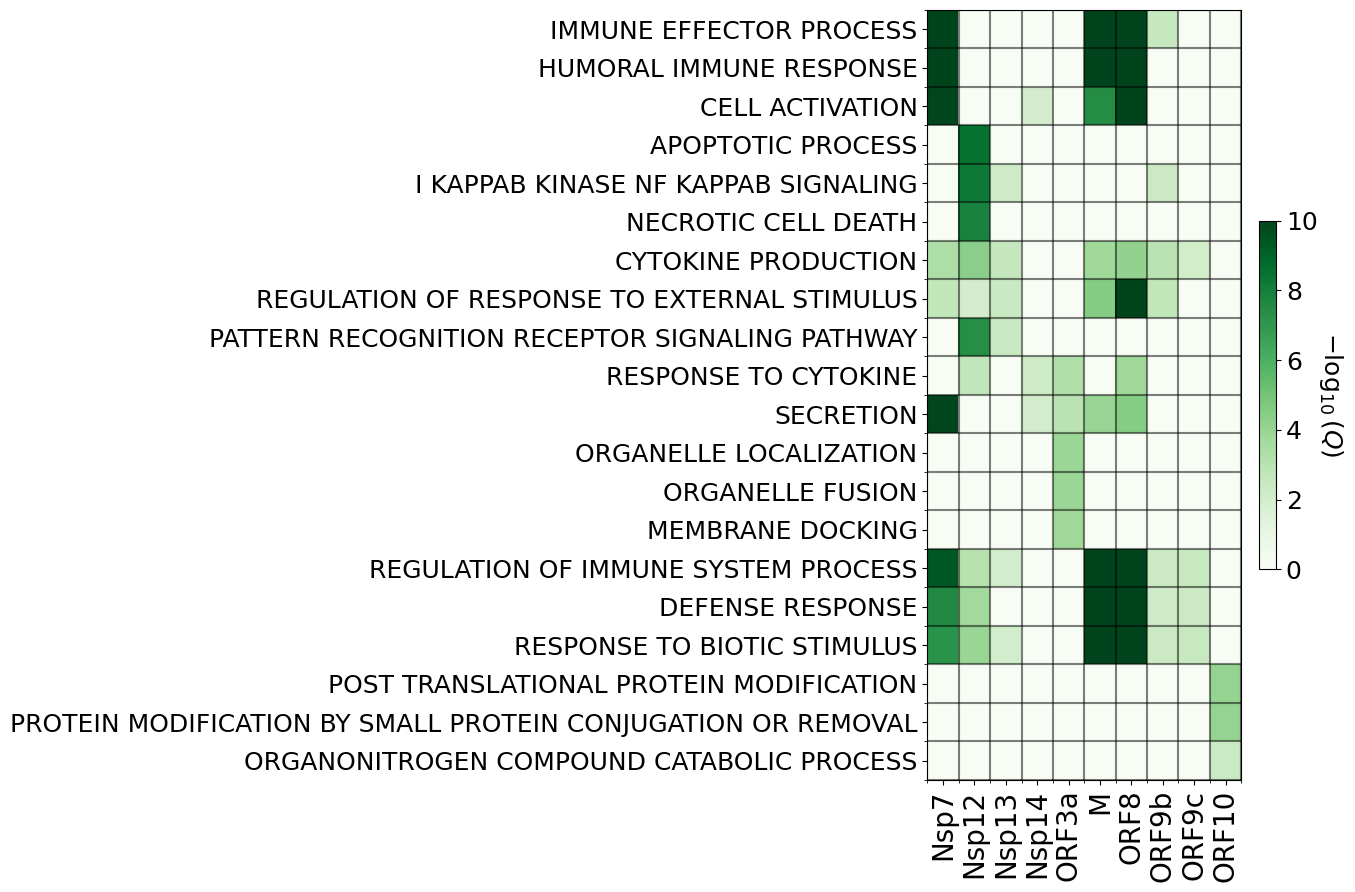

In [23]:
fig, ax = plt.subplots(figsize=(w,l))

plt.imshow(non_zero_q,cmap=cm.Greens,aspect='auto',vmin=0,vmax=c_max)

cbar = plt.colorbar(fraction=0.05,pad=0.05)

ax.set_xticks(np.arange(0,len(non_zero_short_sars)))
ax.set_xticklabels(non_zero_short_sars,fontsize=20,rotation=90)

ax.set_yticks(np.arange(0,len(selected_gos)))
ax.set_yticklabels(selected_gos,fontsize=18)

cbar.set_label(r'$-\log_{10}$($Q$)',fontsize=18,rotation=-90,labelpad=20)
cbar.ax.tick_params(labelsize=18)

ax.set_xticks(np.arange(-.5, len(non_zero_short_sars), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(selected_gos), 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=1.5, alpha=0.5)

In [24]:
go_tags, go_names, p_values = fnGO.compute_p_values(sources,GO_BPs,direct_interaction_set,total_genes)#,size_threshold=gene_set_cutoff)

In [25]:
q_values = {}

for s_g in sources:
    go_tags[s_g], go_names[s_g], q_values[s_g] = fnGO.compute_q_values(p_values[s_g],go_names[s_g],go_tags[s_g],0.01)

In [26]:
total_q = (-math.log10(1))*np.ones(shape=(len(selected_gos),len(sources)))

for i in range(0,len(selected_gos)):
    for j in range(0,len(sources)):
        s_g = sources[j]
        
        try:
            k = go_names[s_g].index(selected_gos[i])
            
            if q_values[s_g][k]<=fdr:         
                total_q[i,j] = -math.log10(q_values[s_g][k])
            else:
                total_q[i,j] = 0.0
                
        except ValueError:
            pass

short_sars = []

for s in sources:
    short_sars.append(s.split(' ')[1])

In [27]:
c_max = 10
r = c_max + math.log10(fdr)
c_min = -math.log10(fdr) - r

print(np.min(total_q))

print(c_max,c_min,r)

-0.0
10 -6.0 8.0


In [28]:
pixel_width = 0.5

l = pixel_width*len(selected_gos)

non_zero_short_sars = []

non_zero_q = np.zeros(shape=total_q.shape)

for i in range(total_q.shape[1]):
    
    if np.sum(total_q[:,i])>0.0:
        non_zero_short_sars.append(short_sars[i])

        if np.sum(non_zero_q)==0.0:
            non_zero_q = total_q[:,i]
        else:
            non_zero_q = np.vstack((non_zero_q,total_q[:,i]))
    
print(non_zero_short_sars)

non_zero_q = np.transpose(non_zero_q)

print(non_zero_q.shape,total_q.shape)
w = 0.9*pixel_width*len(non_zero_short_sars)

['Nsp7', 'ORF8', 'ORF10']
(20, 3) (20, 11)


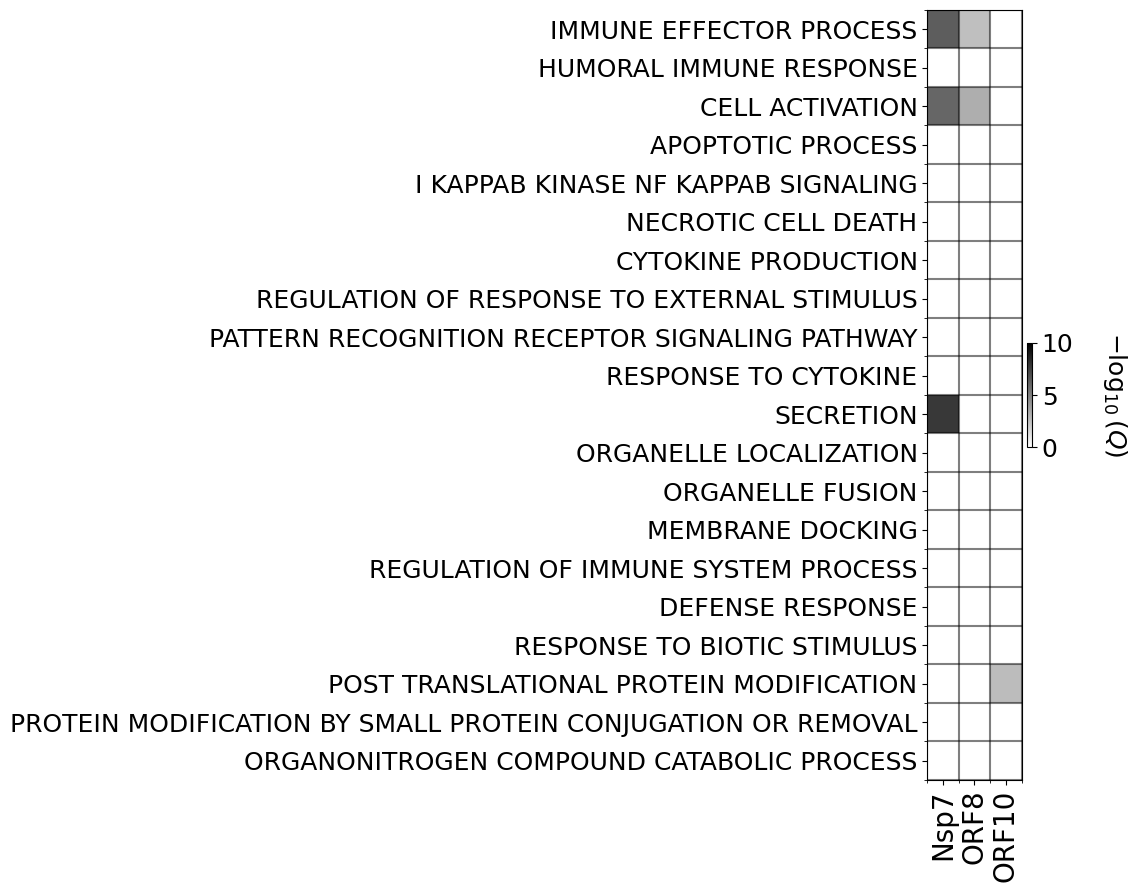

In [29]:
fig, ax = plt.subplots(figsize=(w,l))

plt.imshow(non_zero_q,cmap=cm.binary,aspect='auto',vmin=0,vmax=c_max)

cbar = plt.colorbar(fraction=0.05,pad=0.05)

ax.set_xticks(np.arange(0,len(non_zero_short_sars)))
ax.set_xticklabels(non_zero_short_sars,fontsize=20,rotation=90)

ax.set_yticks(np.arange(0,len(selected_gos)))
ax.set_yticklabels(selected_gos,fontsize=18)

cbar.set_label(r'$-\log_{10}$($Q$)',fontsize=18,rotation=-90,labelpad=40)
cbar.ax.tick_params(labelsize=18)

ax.set_xticks(np.arange(-.5, len(non_zero_short_sars), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(selected_gos), 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=1.5, alpha=0.5)